# Detección de fallas en sensores IoT mediante Machine Learning

El objetivo del presente trabajo es utilizar técnicas de Aprendizaje Automático (Machine Learning) para detectar fallas en sensores IoT. Para ello, utilizaremos 2 datasets obtenidos de la página Kaggle, uno de ellos referidos a la [detección de incendios](https://www.kaggle.com/datasets/deepcontractor/smoke-detection-dataset) y otro refereido a la [detección de ocupantes en una habitación](https://www.kaggle.com/datasets/kukuroo3/room-occupancy-detection-data-iot-sensor).

## Plan de trabajo: Introducción de Ruido

El siguiente procedimiento será igual para ambos datasets y se repetirá para cada sensor:
- Sean $N$ la cantidad de observaciones de entrenamiento, $M$ la cantidad de observaciones de validación cruzada y $T$ la cantidad de observaciones de test.
- Se calculará $\hat{\sigma}$ el estimador del desvio estandar de los datos de entrenamiento.
-  Se realizarán los siguientes pasos para distintos valores de un coeficiente positivo $\alpha$.
-  Se generarán $2*N$ datos como ejemplos de observaciones con el sensor fallado. Estos ejemplos consistirán en la observación original $\pm \alpha * \hat{\sigma}$.
-  Se entrenará el modelo para detectar las observaciones manipuladas de las observaciones originales.
-  Se evaluará el modelo para distintos valores de $\beta$ que indicán la magnitud de los errores introducidos.
-  Para los datos de validación, se tomarán los datos de validación cruzada y nuevamente se generarán $2*M$ datos como ejemplos de observaciones con el sensor fallado. Estos ejemplos consistirán en la observación original $\pm \beta * \hat{\sigma}$.
-  Se evaluará la capacidad del modelo de detectar los fallidos vs los originales.

Se espera que al aumentar $\beta$ sea más fácil para el modelo detectar los casos anomalos. 

## Lectura y limpieza de los datasets

### Lectura y división en entrenamiento, validación y test

In [1]:
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
humo = pd.read_csv('smoke_detection_iot.csv')

humo = humo.dropna().drop(columns=[humo.columns[0], "UTC","Fire Alarm", "CNT"])

ocupacion = pd.read_csv('occupancy.csv')
ocupacion = ocupacion.dropna().drop(columns=["date","Occupancy"])

In [2]:
humo_train, humo_cv, humo_test = np.split(humo.sample(frac=1), [int(.6*len(humo)), int(.8*len(humo))])
ocupacion_train, ocupacion_cv, ocupacion_test = np.split(ocupacion.sample(frac=1), [int(.6*len(ocupacion)), int(.8*len(ocupacion))])

### Exploración de los datos de entrenamiento

In [3]:
# ProfileReport(humo_train)

In [4]:
# ProfileReport(ocupacion_train)

## Definición de los modelos

Para comparar los modelos se crearan clases que envuelvan el modelo y permitan entrenarlo y evaluarlo de forma sencilla.

### Regresión Logística Simple

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
tf.get_logger().setLevel('ERROR')
class ModeloRegresionLogistica:
    @staticmethod
    def nombre():
        return "Regresion Logistica"

    def __init__(self, datos_originales):
        p = datos_originales.shape[1]
        self.modelo = keras.Sequential([
            keras.layers.Input(shape=(p,)),
            keras.layers.Dense(1, activation='sigmoid')
        ])
        self.modelo.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    def entrenar(self, Xs, ys):
        early_stopping = EarlyStopping(
            monitor = 'loss',
            patience = 5,
            restore_best_weights = True,
            verbose = 0,
            mode = 'min'
        )
        self.modelo.fit(Xs,ys, epochs=10, batch_size = 32, verbose=0, callbacks=[early_stopping])
        self.modelo.fit(Xs,ys, epochs=10, batch_size = 64, verbose=0, callbacks=[early_stopping])
        self.modelo.fit(Xs,ys, epochs=10, batch_size = 128, verbose=0, callbacks=[early_stopping])
        self.modelo.fit(Xs,ys, epochs=20, batch_size = 256, verbose=0, callbacks=[early_stopping])
        self.modelo.fit(Xs,ys, epochs=100, batch_size = len(Xs), verbose=0, callbacks=[early_stopping])

    def predecir(self, Xs):
        return (self.modelo.predict(Xs, verbose=0)>0.5).astype(int)

2024-08-21 03:05:58.652142: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-21 03:05:58.745469: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 03:05:58.745592: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 03:05:58.745727: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-21 03:05:58.777639: I tensorflow/core/platform/cpu_feature_g

In [41]:
from sklearn.linear_model import LogisticRegression
class ModeloRegresionLogisticaScikit:
    @staticmethod
    def nombre():
        return "Regresion Logistica"

    def __init__(self, datos_originales):
        self.modelo = LogisticRegression(max_iter=1000)

    def entrenar(self, Xs, ys):
        self.modelo.fit(Xs,ys)

    def predecir(self, Xs):
        return self.modelo.predict(Xs)

### Modelo estadistico de detección de anomalias

Este es un modelo estadistico sencillo.
Consiste en simplemente calcular la probabilidad de que la observación sea generada por la distribución de los datos sin fallas, para lo cuál se la considerará como una normal multivariada. Se fijara el humbral que maximice la precisión en los datos de entrenamiento.

Formalmente:

$$
X \sim N(\mu, \Sigma)        (1)
$$

Donde $\mu$ y $\Sigma$ son los estimadores de la media y la matriz de covarianza de los datos de entrenamiento.

Se pueden acceder facilmente a $\mu$ y $\Sigma$ con *df.mean()* y *df.cov()* respectivamente.

In [7]:
from scipy.stats import multivariate_normal
class ModeloNormalMultivariada:
    
    @staticmethod
    def nombre():
        return "Normal Multivariada"

    def __init__(self, datos_originales):
        self.normal = multivariate_normal(mean=datos_originales.mean().values, cov=datos_originales.cov().values, allow_singular=True)
        
    def entrenar(self, Xs, ys):
        probs = self.normal.pdf(Xs)
        observaciones = list(zip(probs,ys))
        observaciones.sort(key=lambda x: x[0])
        umbral = 0
        pres = 1/3
        optimo = 1/3
        N = len(observaciones)
        for i, (prob, y) in enumerate(observaciones):
            if y == 1:
                pres += 1/N
            else:
                pres -= 1/N
            if pres>optimo:
                optimo = pres
                umbral = prob
        self.umbral = umbral
        self.optimo = optimo
        
    def predecir(self, Xs):
        return self.normal.pdf(Xs) < self.umbral


## Modelo de Bosque Aleatorio (Random Forest)

In [40]:
from sklearn.ensemble import RandomForestClassifier
class ModeloRandomForestScikit:
    @staticmethod
    def nombre():
        return "Random Forest"

    def __init__(self, datos_originales):
        self.modelo = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=0)
        
    def entrenar(self, Xs, ys):
        self.modelo.fit(Xs, ys)
        
    def predecir(self, Xs):
        return self.modelo.predict(Xs)

## Definición de la función de evaluación

Lo siguiente que corresponde es definir la función que utilizaremos para evaluar los modelos definidos en la sección anterior. La función deberá recibir el dataset, la columna a modificar, el modelo a evaluar y las grillas de $\alpha$ y $\beta$ . La función devolvera un diccionario donde la clave será el valor de $\alpha$ utilizado para el entrenamiento y el contenido será un dataframe con los resultados de evaluación para cada valor de $\beta$.

In [9]:
def Generar(Xs, columna, delta):
    Xs_suma = Xs.copy()
    Xs_suma[columna] += delta
    Xs_resta = Xs.copy()
    Xs_resta[columna] -= delta
    ys = np.array([0]*len(Xs) + [1]*2*len(Xs))
    return pd.concat([Xs, Xs_suma, Xs_resta], ignore_index=True), ys

def Evaluar(Xs_train, Xs_cv, columna, Modelo, alfas, betas):
    resultados = dict()
    for alfa in alfas:
        modelo = Modelo(Xs_train)
        desvio = np.std(Xs_train[columna])
        Xs_train_alfa, ys_train_alfa = Generar(Xs_train, columna, desvio*alfa)
        modelo.entrenar(Xs_train_alfa, ys_train_alfa)

        resultados_alfa = list()
        for beta in betas:
            Xs_cv_beta, ys_cv_beta = Generar(Xs_cv, columna, desvio*beta)
            preds = modelo.predecir(Xs_cv_beta)
            resultados_alfa.append(np.mean(preds == ys_cv_beta))
        resultados[alfa] = np.array(resultados_alfa)
    return resultados


In [10]:
from tqdm.notebook import tqdm
from time import time
def Evaluacion_Global(Xs_train, Xs_cv, Modelos, alfas, betas):
    Resultados = list()
    avance = tqdm(total=len(Modelos)*len(Xs_train.columns))
    for Modelo in Modelos:
        resultados_modelo = list()
        t0 = time()
        for columna in Xs_train.columns:
            resultados = Evaluar(Xs_train, Xs_cv, columna, Modelo, alfas, betas)
            resultados_modelo.append(resultados)
            avance.update(1)
        t1 = time()
        print(f"Modelo {Modelo.nombre()} en {t1-t0:.2f} segundos")
        Resultados.append(resultados_modelo)
    return Resultados

## Generación de Resultados

In [19]:
Modelos = [
    #ModeloRegresionLogistica,
    ModeloRegresionLogisticaScikit,
    ModeloNormalMultivariada,
    ModeloRandomForestScikit
]
alfas = np.linspace(0, 6, 11)[1:]
betas = np.linspace(0, 6, 31)[1:]

In [12]:
Resultados_Ocupacion = Evaluacion_Global(ocupacion_train, ocupacion_cv, Modelos, alfas, betas)

  0%|          | 0/15 [00:00<?, ?it/s]

Modelo Regresion Logistica Scikit en 53.00 segundos
Modelo Normal Multivariada en 16.44 segundos
Modelo Random Forest en 83.92 segundos


In [13]:
Resultados_Humo = Evaluacion_Global(humo_train, humo_cv, Modelos, alfas, betas)

  0%|          | 0/36 [00:00<?, ?it/s]

Modelo Regresion Logistica Scikit en 477.81 segundos
Modelo Normal Multivariada en 104.68 segundos
Modelo Random Forest en 720.12 segundos


## Representación gráfica de los resultados

In [14]:
import matplotlib.pyplot as plt
def Graficar(Nombre, Resultados, Modelos, Xs_train, alfas, betas, colores):
    n_columnas = len(Xs_train.columns)
    n_modelos = len(Resultados)
    fig, axs = plt.subplots(n_columnas, n_modelos, figsize=(n_modelos * 7, n_columnas * 3.5),constrained_layout=True)
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)
    fig.suptitle(Nombre, fontsize=24)
    if n_modelos == 1 and n_columnas == 1:
        axs = np.array([[axs]])  # Hacer que axs sea 2D
    elif n_modelos == 1:
        axs = np.expand_dims(axs, axis=-1)  # Convertir a un array 2D con una única columna
    elif n_columnas == 1:
        axs = np.expand_dims(axs, axis=0) 
    
    for i, (modelo, resultados_modelo) in enumerate(zip(Modelos,Resultados)):
        for j, resultados_columna in enumerate(resultados_modelo):
            ax = axs[j,i]
            for (alfa, resultados_alfa) in resultados_columna.items(): 
                ax.plot(betas, resultados_alfa, label=f"$\\alpha$={round(alfa,1)}",
                        color = (colores[i][0], colores[i][1], colores[i][2], 1-0.7*alfa/max(alfas)))
            ax.set_title(f"{Xs_train.columns[j]} | {modelo.nombre()}", fontsize = 16)
            ax.set_xlabel("$\\beta$")
            ax.set_ylabel("Accuracy")
            ax.legend()
            ax.grid()
            ax.set_ylim(0,1)
    #plt.legend()
    plt.show()
    return (fig,axs)

/tmp/ipykernel_974194/570639156.py:6: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)


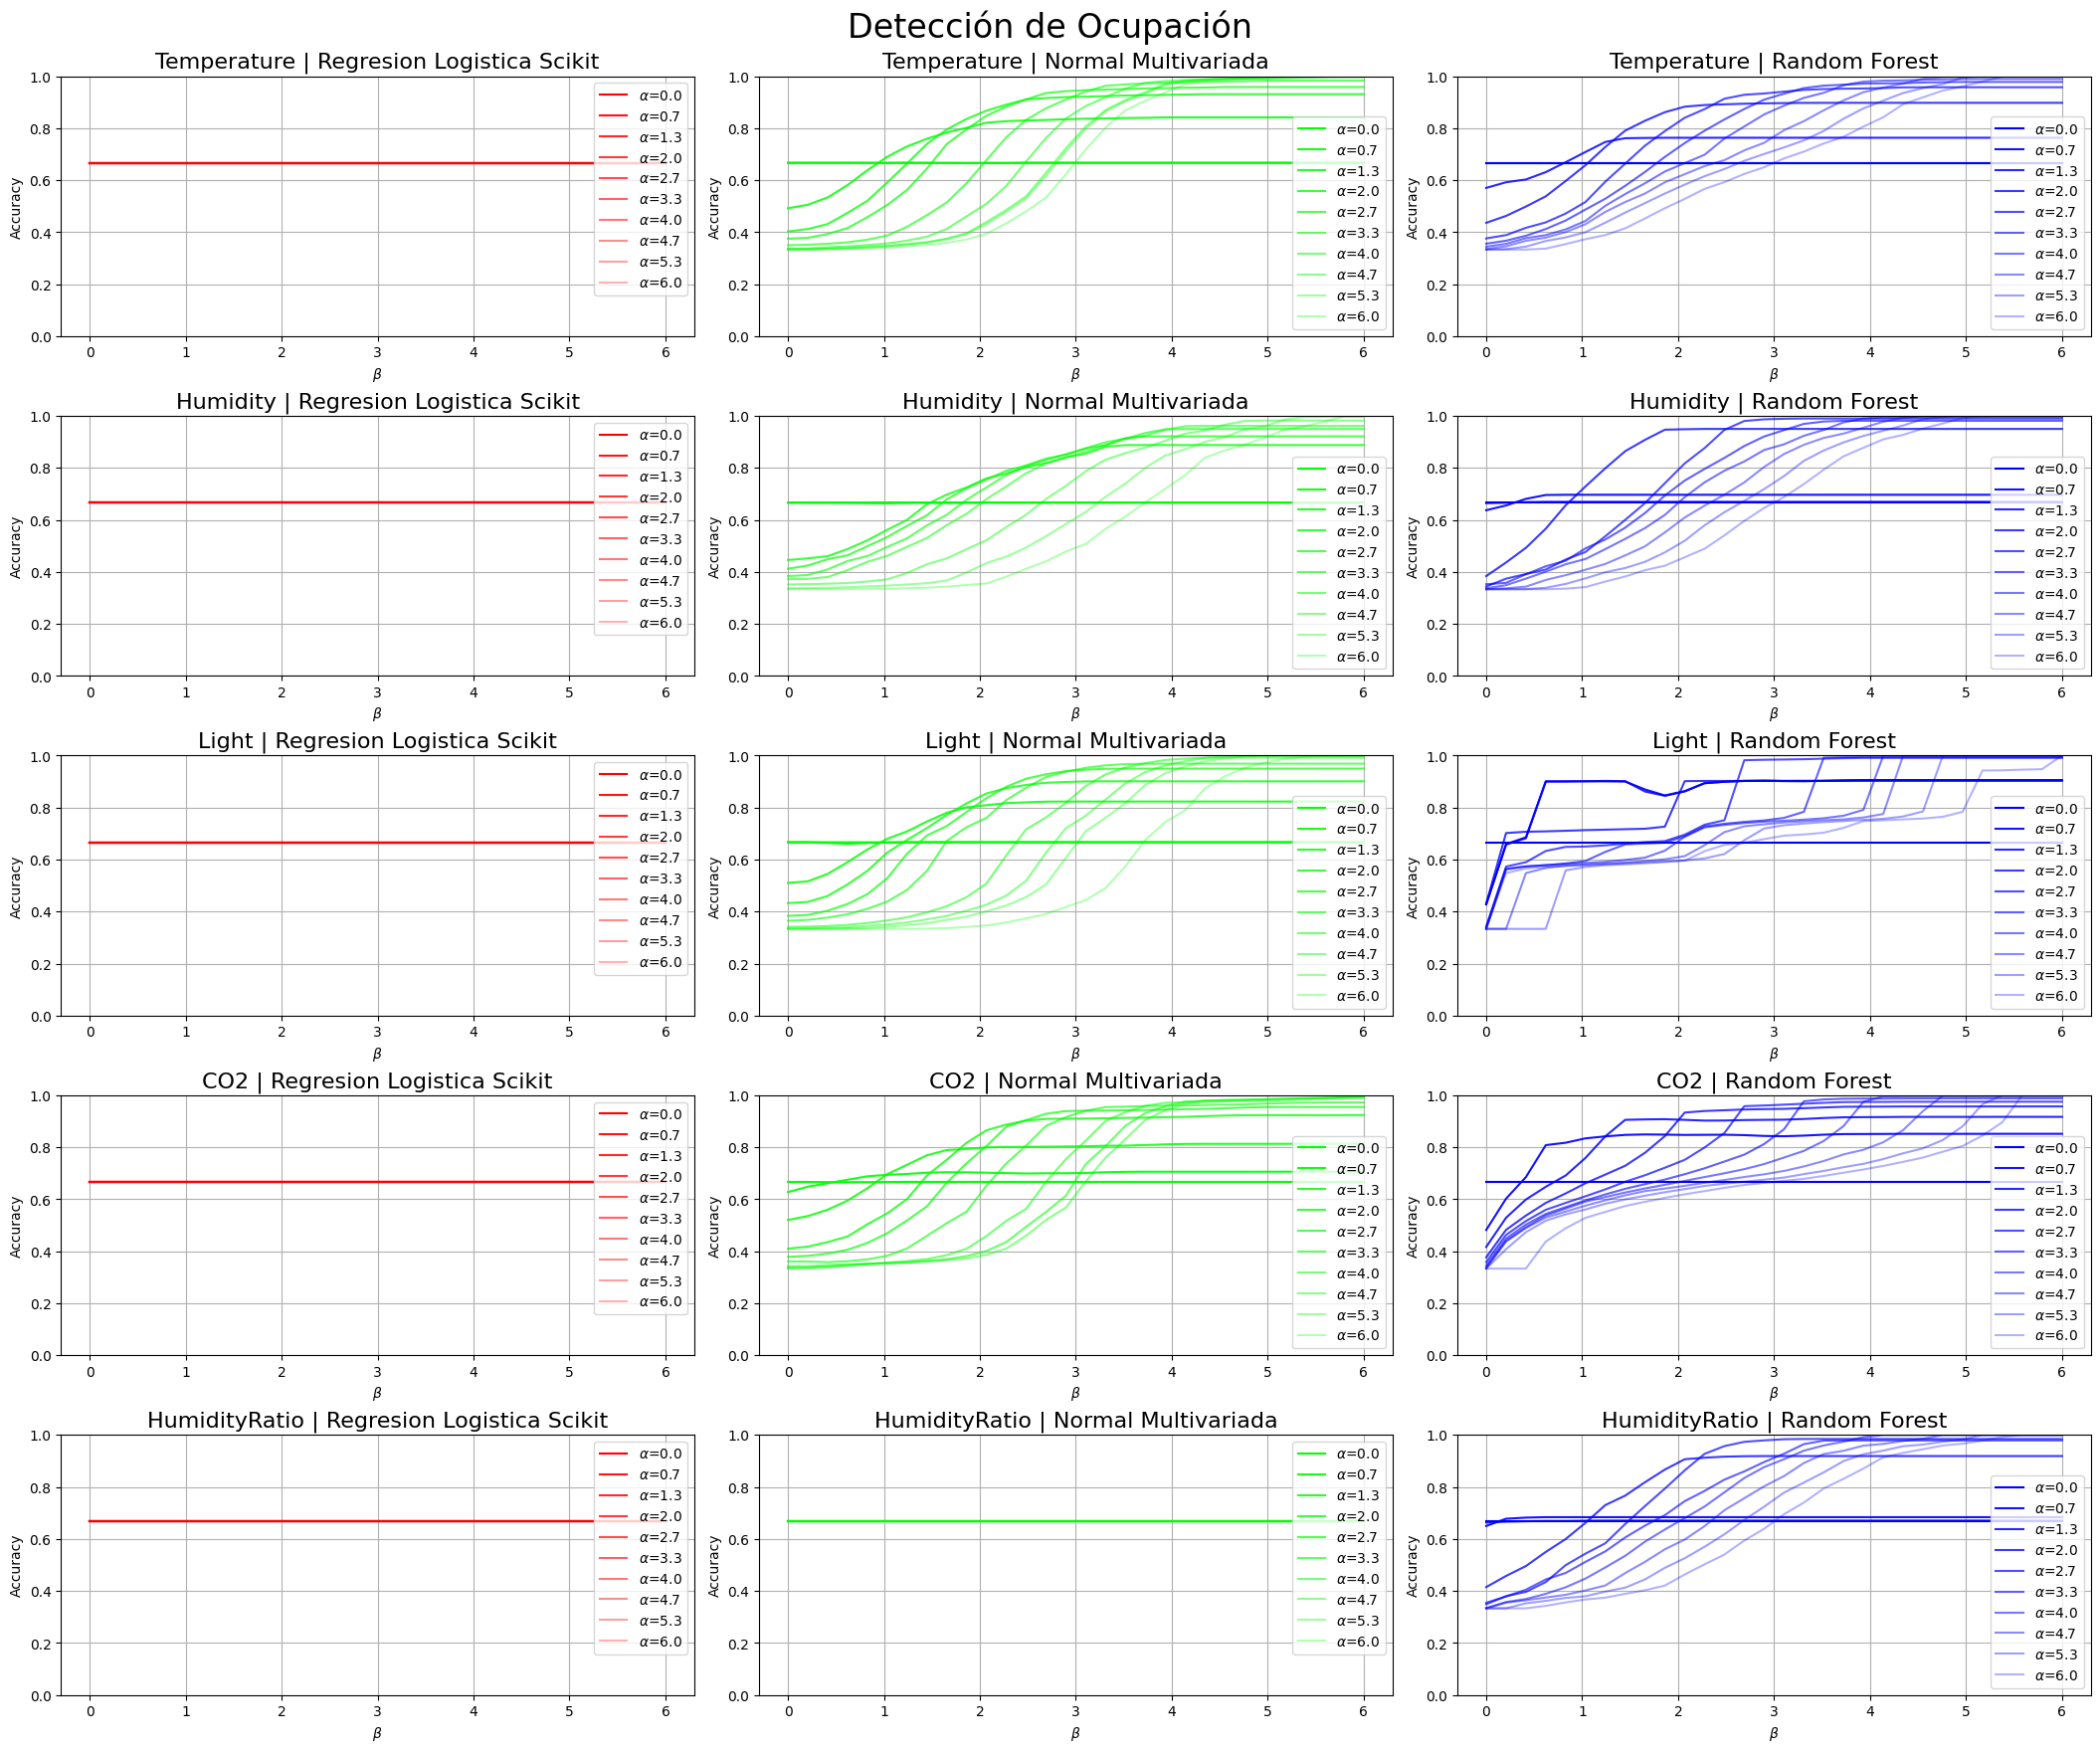

(<Figure size 2100x1750 with 15 Axes>,
 array([[<Axes: title={'center': 'Temperature | Regresion Logistica Scikit'}, xlabel='$\\beta$', ylabel='Accuracy'>,
         <Axes: title={'center': 'Temperature | Normal Multivariada'}, xlabel='$\\beta$', ylabel='Accuracy'>,
         <Axes: title={'center': 'Temperature | Random Forest'}, xlabel='$\\beta$', ylabel='Accuracy'>],
        [<Axes: title={'center': 'Humidity | Regresion Logistica Scikit'}, xlabel='$\\beta$', ylabel='Accuracy'>,
         <Axes: title={'center': 'Humidity | Normal Multivariada'}, xlabel='$\\beta$', ylabel='Accuracy'>,
         <Axes: title={'center': 'Humidity | Random Forest'}, xlabel='$\\beta$', ylabel='Accuracy'>],
        [<Axes: title={'center': 'Light | Regresion Logistica Scikit'}, xlabel='$\\beta$', ylabel='Accuracy'>,
         <Axes: title={'center': 'Light | Normal Multivariada'}, xlabel='$\\beta$', ylabel='Accuracy'>,
         <Axes: title={'center': 'Light | Random Forest'}, xlabel='$\\beta$', ylabel='Accur

In [15]:
Graficar("Detección de Ocupación", 
         Resultados_Ocupacion, Modelos, ocupacion_train, 
         alfas, betas, [(1,0,0), (0,1,0), (0,0,1)])

/tmp/ipykernel_974194/570639156.py:6: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)


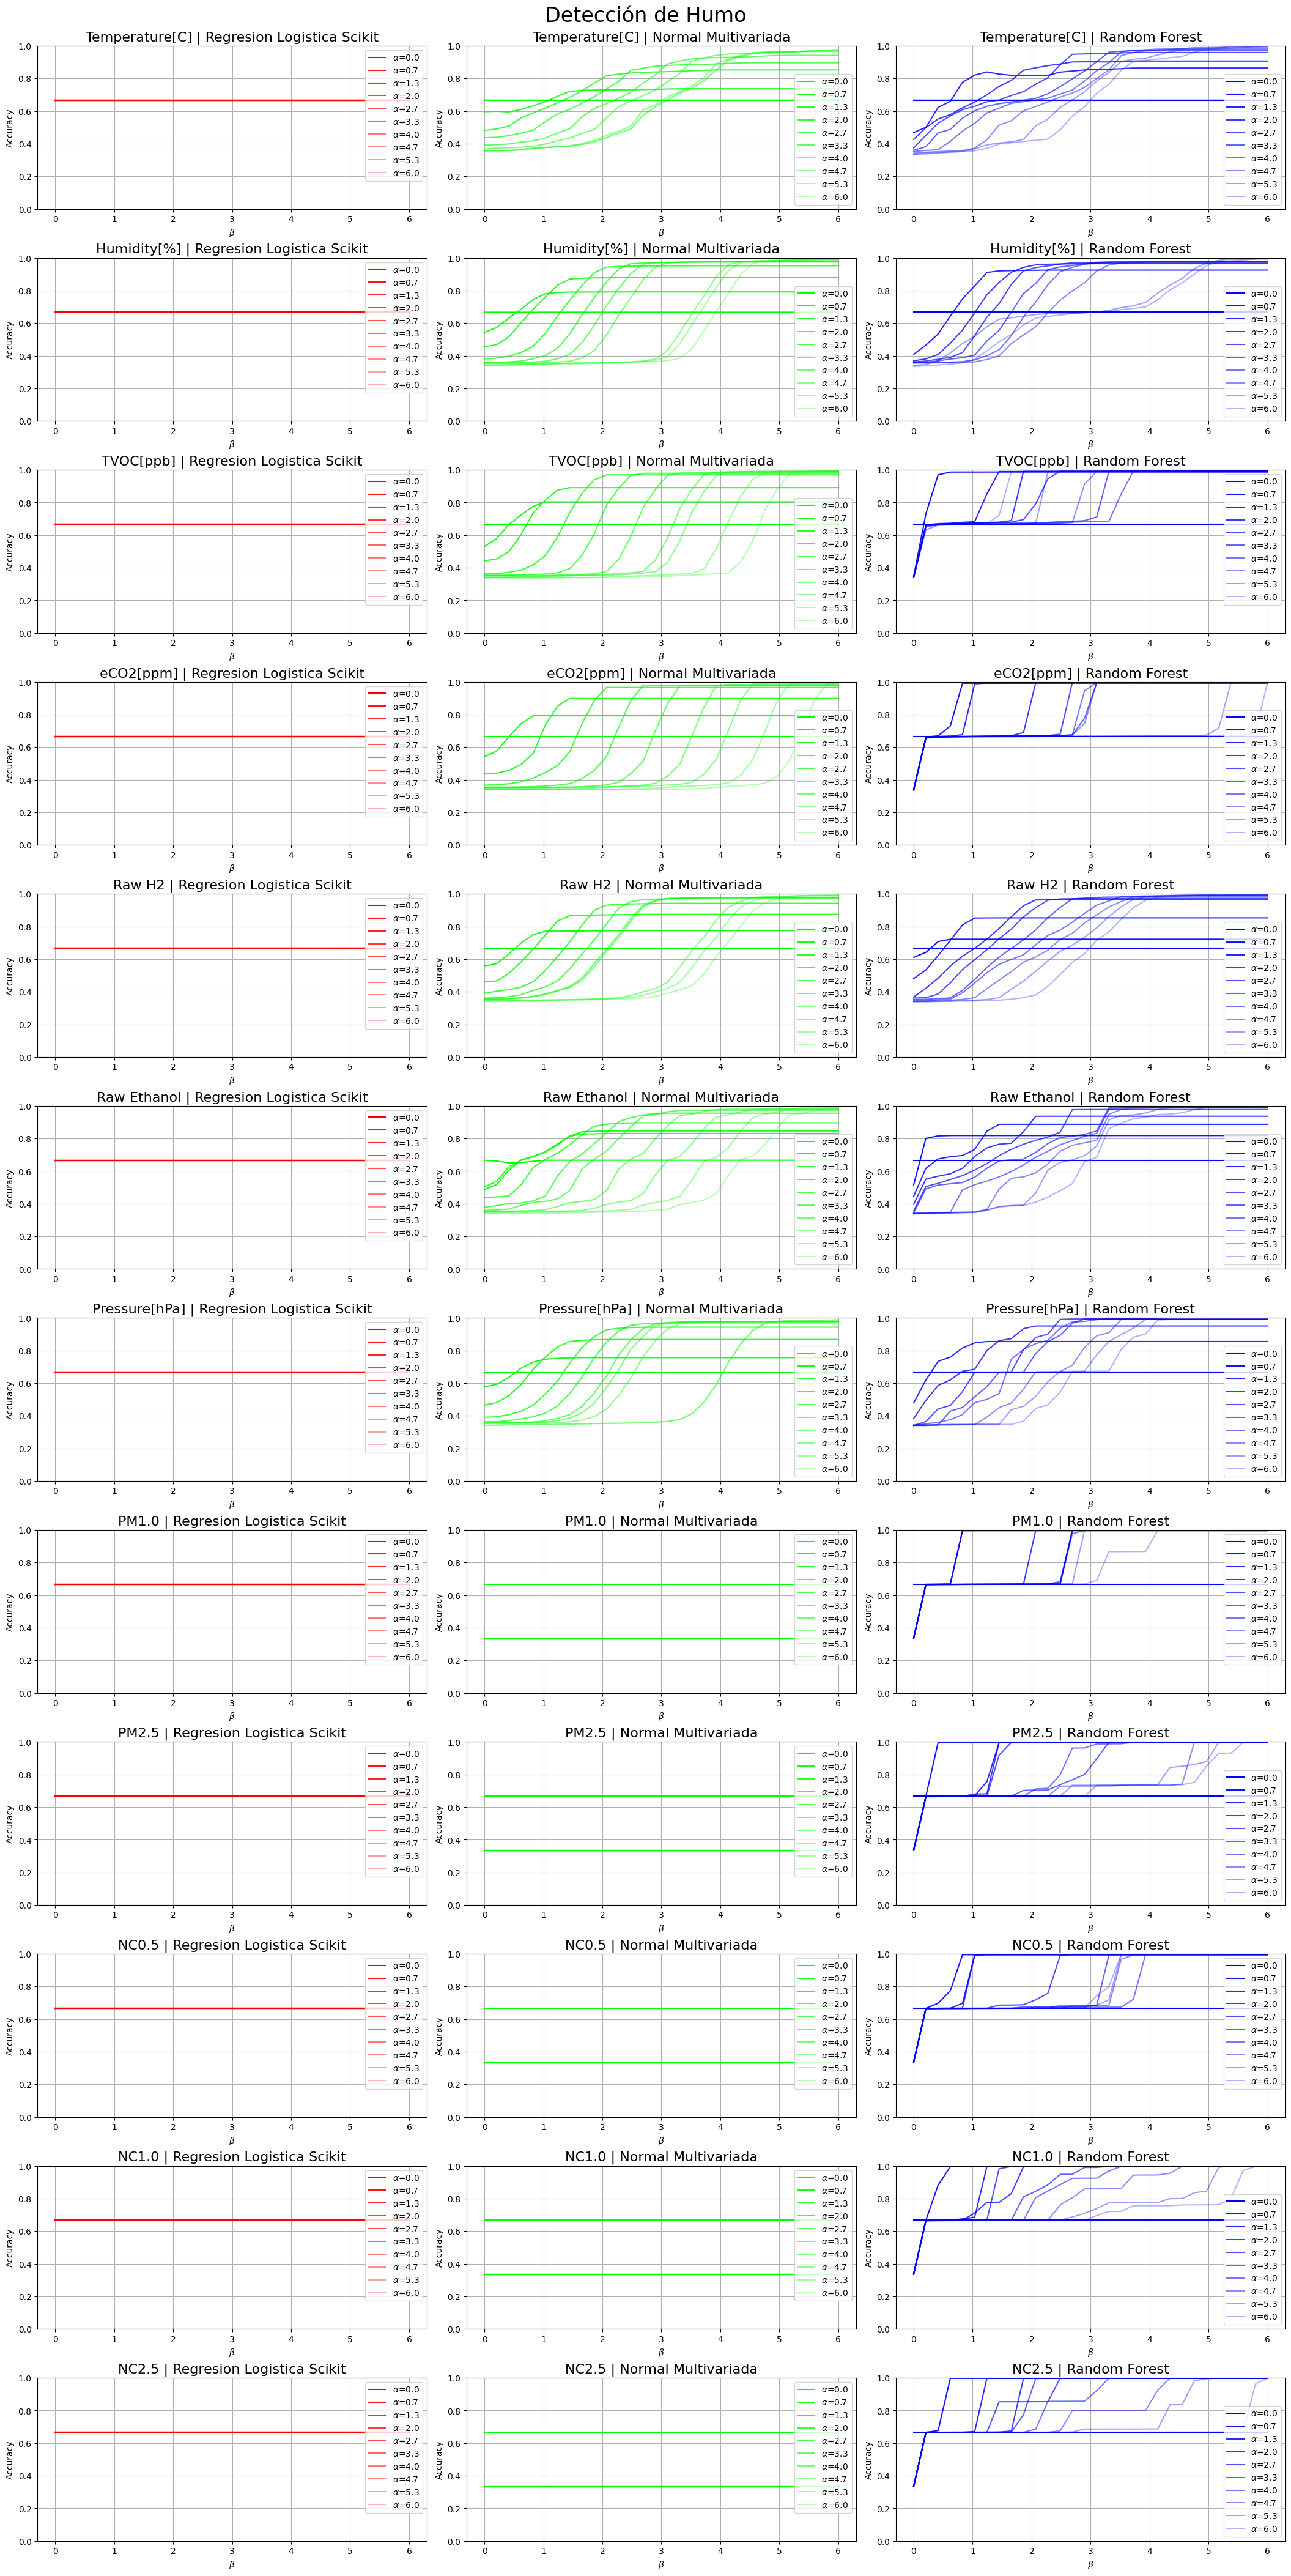

(<Figure size 2100x4200 with 36 Axes>,
 array([[<Axes: title={'center': 'Temperature[C] | Regresion Logistica Scikit'}, xlabel='$\\beta$', ylabel='Accuracy'>,
         <Axes: title={'center': 'Temperature[C] | Normal Multivariada'}, xlabel='$\\beta$', ylabel='Accuracy'>,
         <Axes: title={'center': 'Temperature[C] | Random Forest'}, xlabel='$\\beta$', ylabel='Accuracy'>],
        [<Axes: title={'center': 'Humidity[%] | Regresion Logistica Scikit'}, xlabel='$\\beta$', ylabel='Accuracy'>,
         <Axes: title={'center': 'Humidity[%] | Normal Multivariada'}, xlabel='$\\beta$', ylabel='Accuracy'>,
         <Axes: title={'center': 'Humidity[%] | Random Forest'}, xlabel='$\\beta$', ylabel='Accuracy'>],
        [<Axes: title={'center': 'TVOC[ppb] | Regresion Logistica Scikit'}, xlabel='$\\beta$', ylabel='Accuracy'>,
         <Axes: title={'center': 'TVOC[ppb] | Normal Multivariada'}, xlabel='$\\beta$', ylabel='Accuracy'>,
         <Axes: title={'center': 'TVOC[ppb] | Random Forest'}, xl

In [16]:
Graficar("Detección de Humo", 
         Resultados_Humo, Modelos, humo_train, 
         alfas, betas, [(1,0,0), (0,1,0), (0,0,1)])

/tmp/ipykernel_974194/570639156.py:6: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)


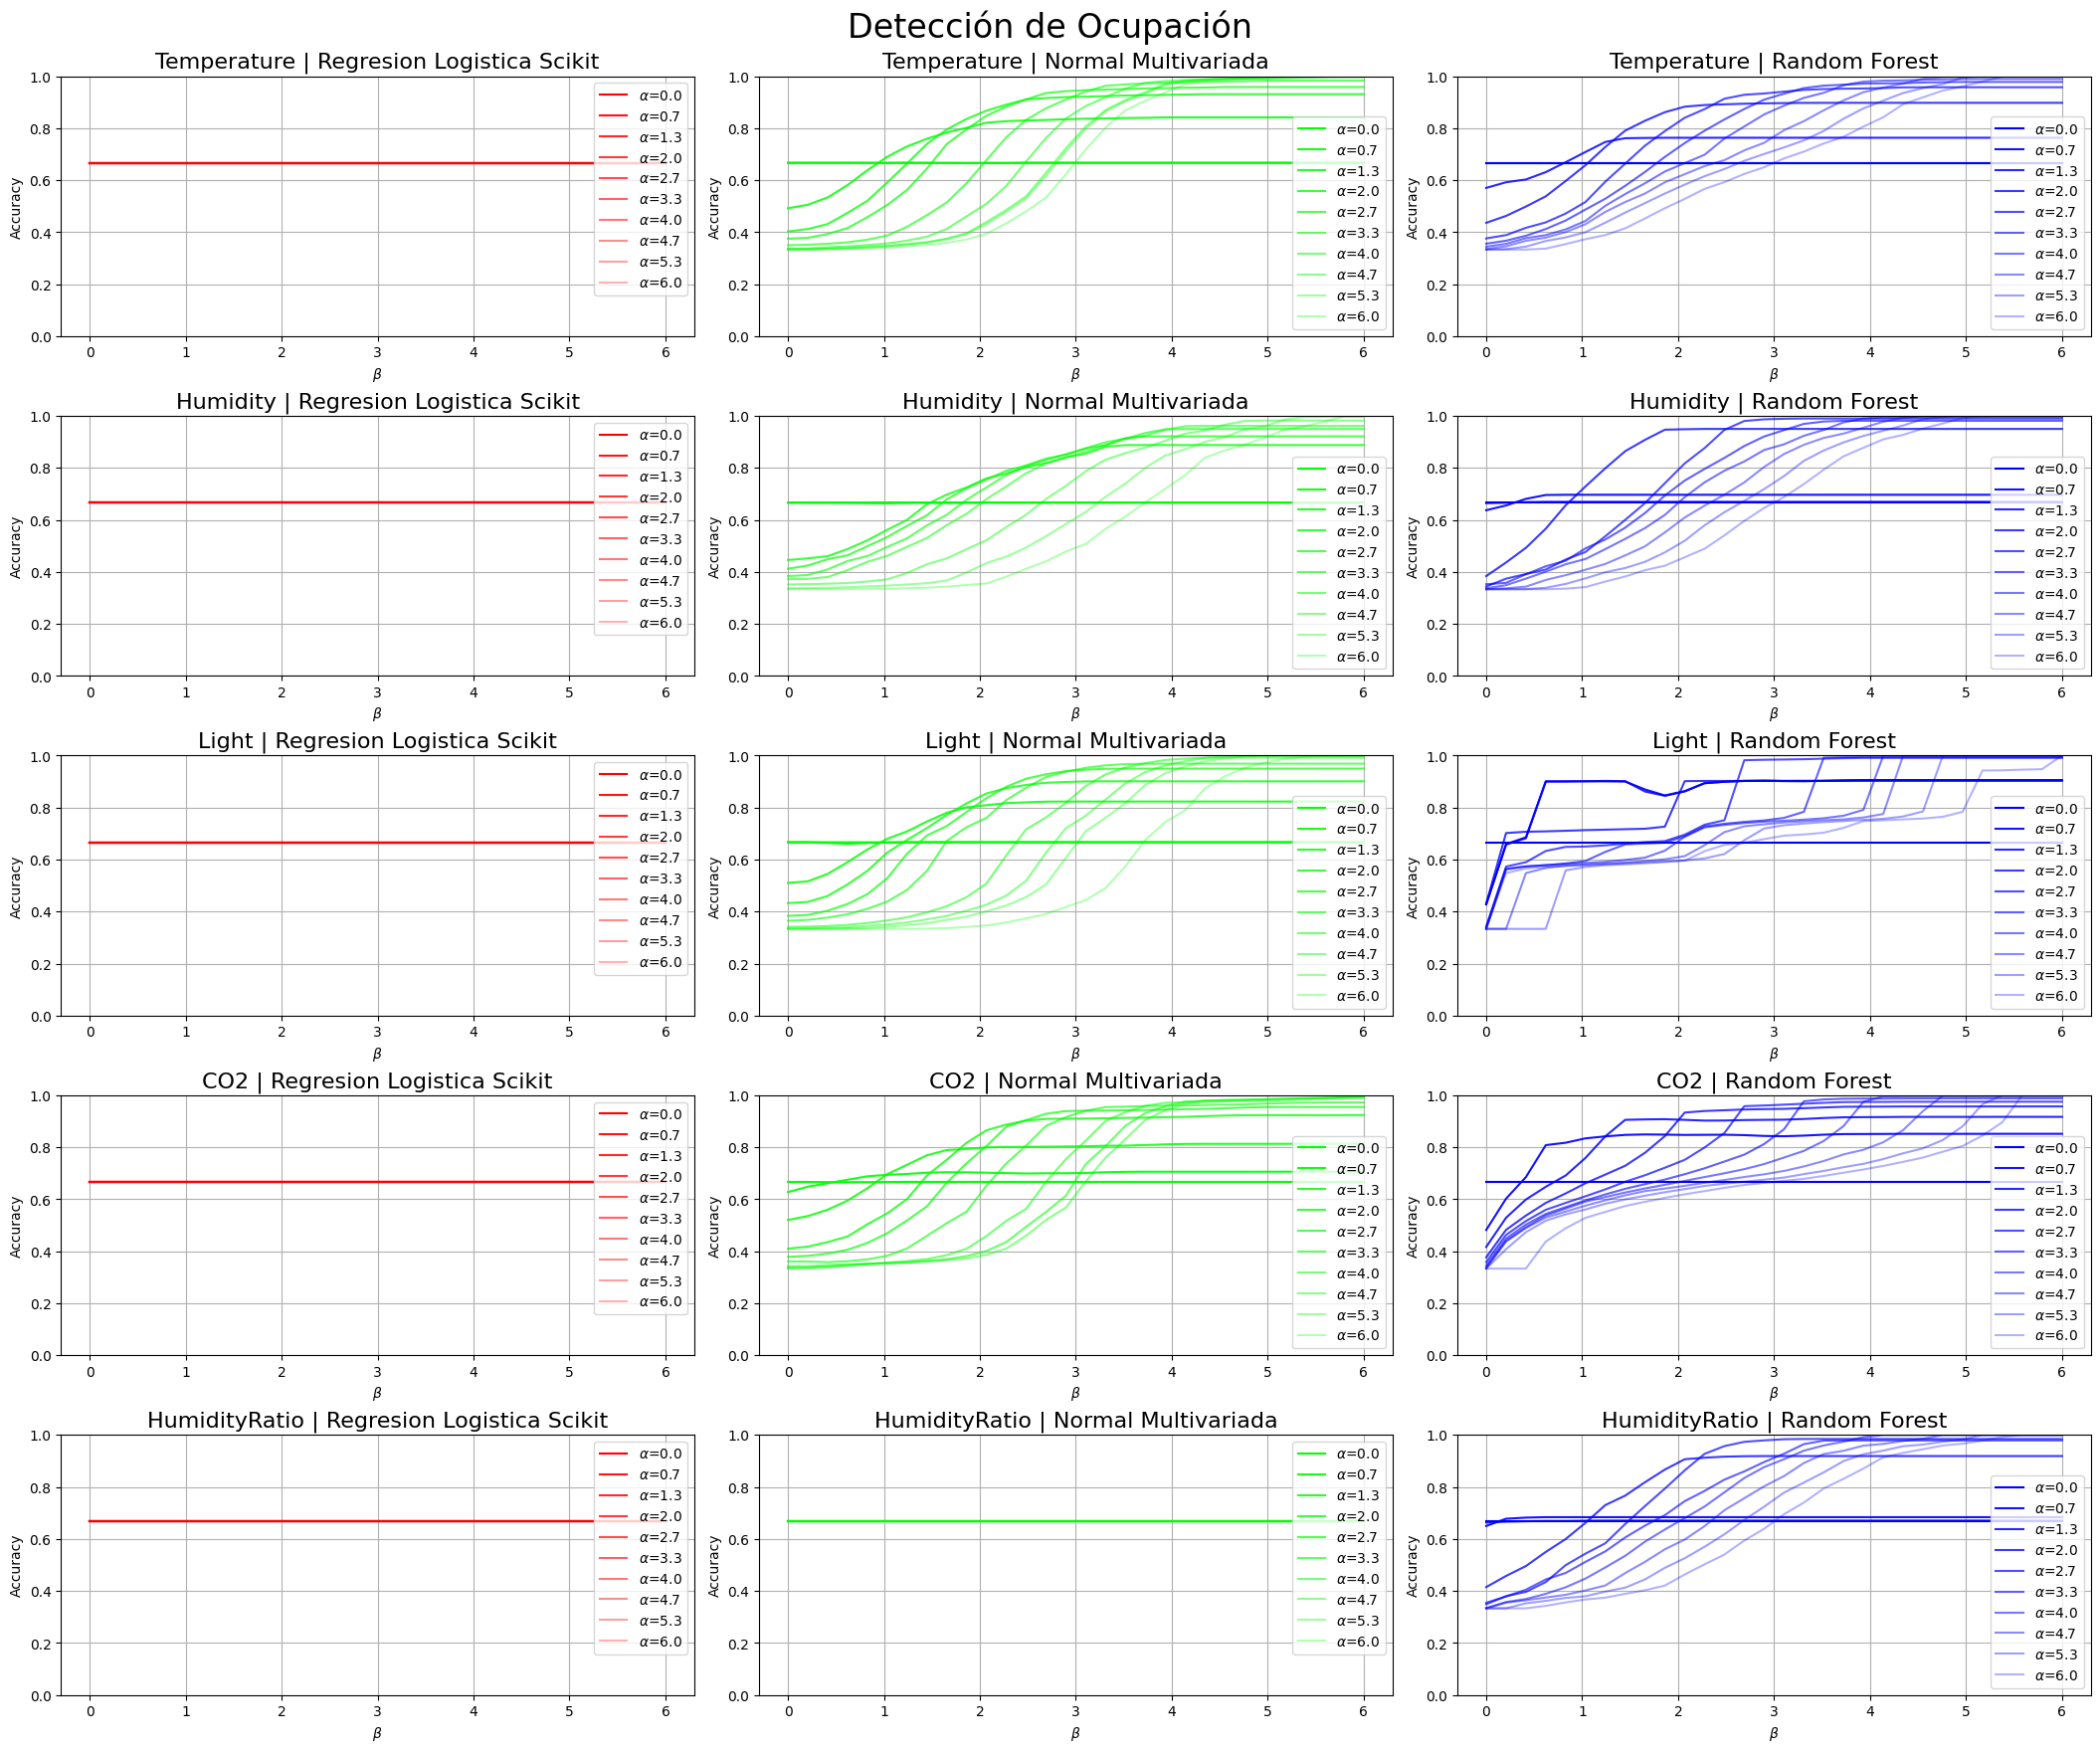

(<Figure size 2100x1750 with 15 Axes>,
 array([[<Axes: title={'center': 'Temperature | Regresion Logistica Scikit'}, xlabel='$\\beta$', ylabel='Accuracy'>,
         <Axes: title={'center': 'Temperature | Normal Multivariada'}, xlabel='$\\beta$', ylabel='Accuracy'>,
         <Axes: title={'center': 'Temperature | Random Forest'}, xlabel='$\\beta$', ylabel='Accuracy'>],
        [<Axes: title={'center': 'Humidity | Regresion Logistica Scikit'}, xlabel='$\\beta$', ylabel='Accuracy'>,
         <Axes: title={'center': 'Humidity | Normal Multivariada'}, xlabel='$\\beta$', ylabel='Accuracy'>,
         <Axes: title={'center': 'Humidity | Random Forest'}, xlabel='$\\beta$', ylabel='Accuracy'>],
        [<Axes: title={'center': 'Light | Regresion Logistica Scikit'}, xlabel='$\\beta$', ylabel='Accuracy'>,
         <Axes: title={'center': 'Light | Normal Multivariada'}, xlabel='$\\beta$', ylabel='Accuracy'>,
         <Axes: title={'center': 'Light | Random Forest'}, xlabel='$\\beta$', ylabel='Accur

In [ ]:
Graficar("Detección de Ocupación", 
         Resultados_Ocupacion, Modelos, ocupacion_train, 
         alfas, betas, [(1,0,0), (0,1,0), (0,0,1)])

# Detección de fallas con modelos multicategoricos

En las etapas anteriores se ha buscado detectar las fallas de cada sensor de forma individual haciendo foco en si ese sensor funciona correctamente o no. 

Otra posibilidad es entrenar un unico modelo que, sean $p$ los sensores, tenga $p+1$ categorias, una para cada sensor fallado y una para indicar que todos los sensores funcionan correctamente.



## Modelos

Convenientemente, los modelos antes definidos **Regresion Logistica Scikit Learn** y **Random Forest Scikit Learn** pueden ser utilizados para este caso ya que soporta multiples categorias de forma nativa.

Sin embargo, como hay que entrenar un modelo en vez de $p$ modelos, podemos permitirnos entrenar modelos más complejos, por lo cuál crearemos nuevas versiones de los modelos que tengan una mayor complejidad

### Regresión Logística Multinomial

In [42]:
class ModeloRegresionLogisticaMultinomial:
    @staticmethod
    def nombre():
        return "Regresion Logistica Multinomial"
    
    def __init__(self, datos_originales):
        self.modelo = LogisticRegression(multi_class='multinomial', max_iter=10000)

    def entrenar(self, Xs, ys):
        self.modelo.fit(Xs,ys)
    
    def predecir(self, Xs):
        return self.modelo.predict(Xs)

### Random Forest Multinomial

In [43]:
class ModeloRandomForestMultinomial:
    @staticmethod
    def nombre():
        return "Random Forest Multinomial"

    def __init__(self, datos_originales):
        self.modelo = RandomForestClassifier(n_estimators=400, max_depth=8, random_state=0)
        
    def entrenar(self, Xs, ys):
        self.modelo.fit(Xs, ys)
        
    def predecir(self, Xs):
        return self.modelo.predict(Xs)

## Evaluación

In [44]:
def Generar_Multicategoria(Xs, stds, alfa, ratio):
    array_X = [Xs]
    array_Y = [np.array([0]*len(Xs))]
    for i in range(ratio):
        Xs_i = Xs.copy()
        random = np.random.randint(0,len(Xs.columns),len(Xs))
        Xs_i.iloc[:,random] += stds[random]*alfa
        array_X.append(Xs_i)
        array_Y.append(random+1)
    return pd.concat(array_X, ignore_index=True), np.concatenate(array_Y)

def Evaluar_Multicategoria(Xs_train, Xs_cv, Modelo, alfas, betas, ratio = 2, tqdm_bar = None):
    resultados = dict()
    for alfa in alfas:
        modelo = Modelo(Xs_train)
        desvios = Xs_train.std()
        Xs_train_alfa, ys_train_alfa = Generar_Multicategoria(Xs_train, desvios, alfa, ratio)
        modelo.entrenar(Xs_train_alfa, ys_train_alfa)
        resultados_alfa = list()
        for beta in betas:
            Xs_cv_beta, ys_cv_beta = Generar_Multicategoria(Xs_cv, desvios, beta, ratio)
            preds = modelo.predecir(Xs_cv_beta)
            resultados_alfa.append(np.mean(preds == ys_cv_beta))
        resultados[alfa] = np.array(resultados_alfa)
        if tqdm_bar is not None:
            tqdm_bar.update(1)
    return resultados

In [34]:
def Evaluacion_Global_Multicategoria(Xs_train, Xs_cv, Modelos, alfas, betas, ratio = 2):
    Resultados = list()
    avance = tqdm(total=len(Modelos) * len(alfas))
    for Modelo in Modelos:
        t0 = time()
        resultados = Evaluar_Multicategoria(Xs_train, Xs_cv, Modelo, alfas, betas, ratio = ratio, tqdm_bar = avance)
        t1 = time()
        print(f"Modelo {Modelo.nombre()} en {t1-t0:.2f} segundos")
        Resultados.append(resultados)
    return Resultados

## Generar resultados

In [45]:
Modelos_MC = [
    ModeloRegresionLogisticaMultinomial,
    ModeloRandomForestMultinomial,
]

alfas_mc = np.linspace(0,6,7)[1:]
betas_mc = np.linspace(0,6,31)[1:]

In [46]:
Resultados_MC = Evaluacion_Global_Multicategoria(ocupacion_train, ocupacion_cv, Modelos_MC, alfas_mc, betas_mc, ratio = 3)

  0%|          | 0/12 [00:00<?, ?it/s]

/home/lautaro/anaconda3/envs/data_11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/lautaro/anaconda3/envs/data_11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/lautaro/anaconda3/envs/data_11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the docume

Modelo Regresion Logistica Multinomial en 948.04 segundos
Modelo Random Forest Multinomial en 116.51 segundos


## Graficar resultados

In [52]:
print(Resultados_MC[0][0])

{1.0: array([0.24136673, 0.24878405, 0.26489543, 0.2891537 , 0.30538667,
       0.323018  , 0.33979815, 0.35092412, 0.3541464 , 0.35329523,
       0.3542072 , 0.35706469, 0.35973979, 0.35481518, 0.36040856,
       0.35445039, 0.36046936, 0.35244407, 0.35524076, 0.35645671,
       0.35657831, 0.35834144, 0.35828064, 0.35134971, 0.35992218,
       0.35894942, 0.35797665, 0.35299125, 0.35645671, 0.3566999 ]), 2.0: array([0.24920963, 0.25796449, 0.2708536 , 0.27912208, 0.29620623,
       0.31839737, 0.33432636, 0.35384241, 0.36800827, 0.37743191,
       0.37639835, 0.38764591, 0.38722033, 0.39208414, 0.38965224,
       0.38126216, 0.38630837, 0.3905642 , 0.38411965, 0.38728113,
       0.38320768, 0.38563959, 0.38606518, 0.38211333, 0.38691634,
       0.38788911, 0.38928745, 0.3853964 , 0.39044261, 0.38703794]), 3.0: array([0.25273589, 0.25559339, 0.26009241, 0.27042802, 0.27383268,
       0.28094601, 0.28313473, 0.28769455, 0.29237597, 0.30496109,
       0.32769942, 0.35262646, 0.36217169,

In [38]:
def Graficar_Multicategoria(Nombre, Resultados, Modelos, Xs_train, alfas, betas, colores):
    n_columnas = len(Xs_train.columns)
    n_modelos = len(Resultados)
    fig, axs = plt.subplots(1, n_modelos, figsize=(n_modelos * 7, n_columnas * 3.5),constrained_layout=True)
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)
    fig.suptitle(Nombre, fontsize=24)
    
    for i, (modelo, resultados_modelo) in enumerate(zip(Modelos,Resultados)):
        ax = axs[i]
        for (alfa, resultados_alfa) in resultados_modelo.items(): 
            ax.plot(betas, resultados_alfa, label=f"$\\alpha$={round(alfa,1)}",
                    color = (colores[i][0], colores[i][1], colores[i][2], 1-0.7*alfa/max(alfas)))
            ax.set_title(f"{modelo.nombre()}", fontsize = 16)
            ax.set_xlabel("$\\beta$")
            ax.set_ylabel("Accuracy")
            ax.legend()
            ax.grid()
            ax.set_ylim(0,1)
    #plt.legend()
    plt.show()
    return (fig,axs)

/tmp/ipykernel_974194/2267120382.py:5: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)


AttributeError: 'list' object has no attribute 'items'

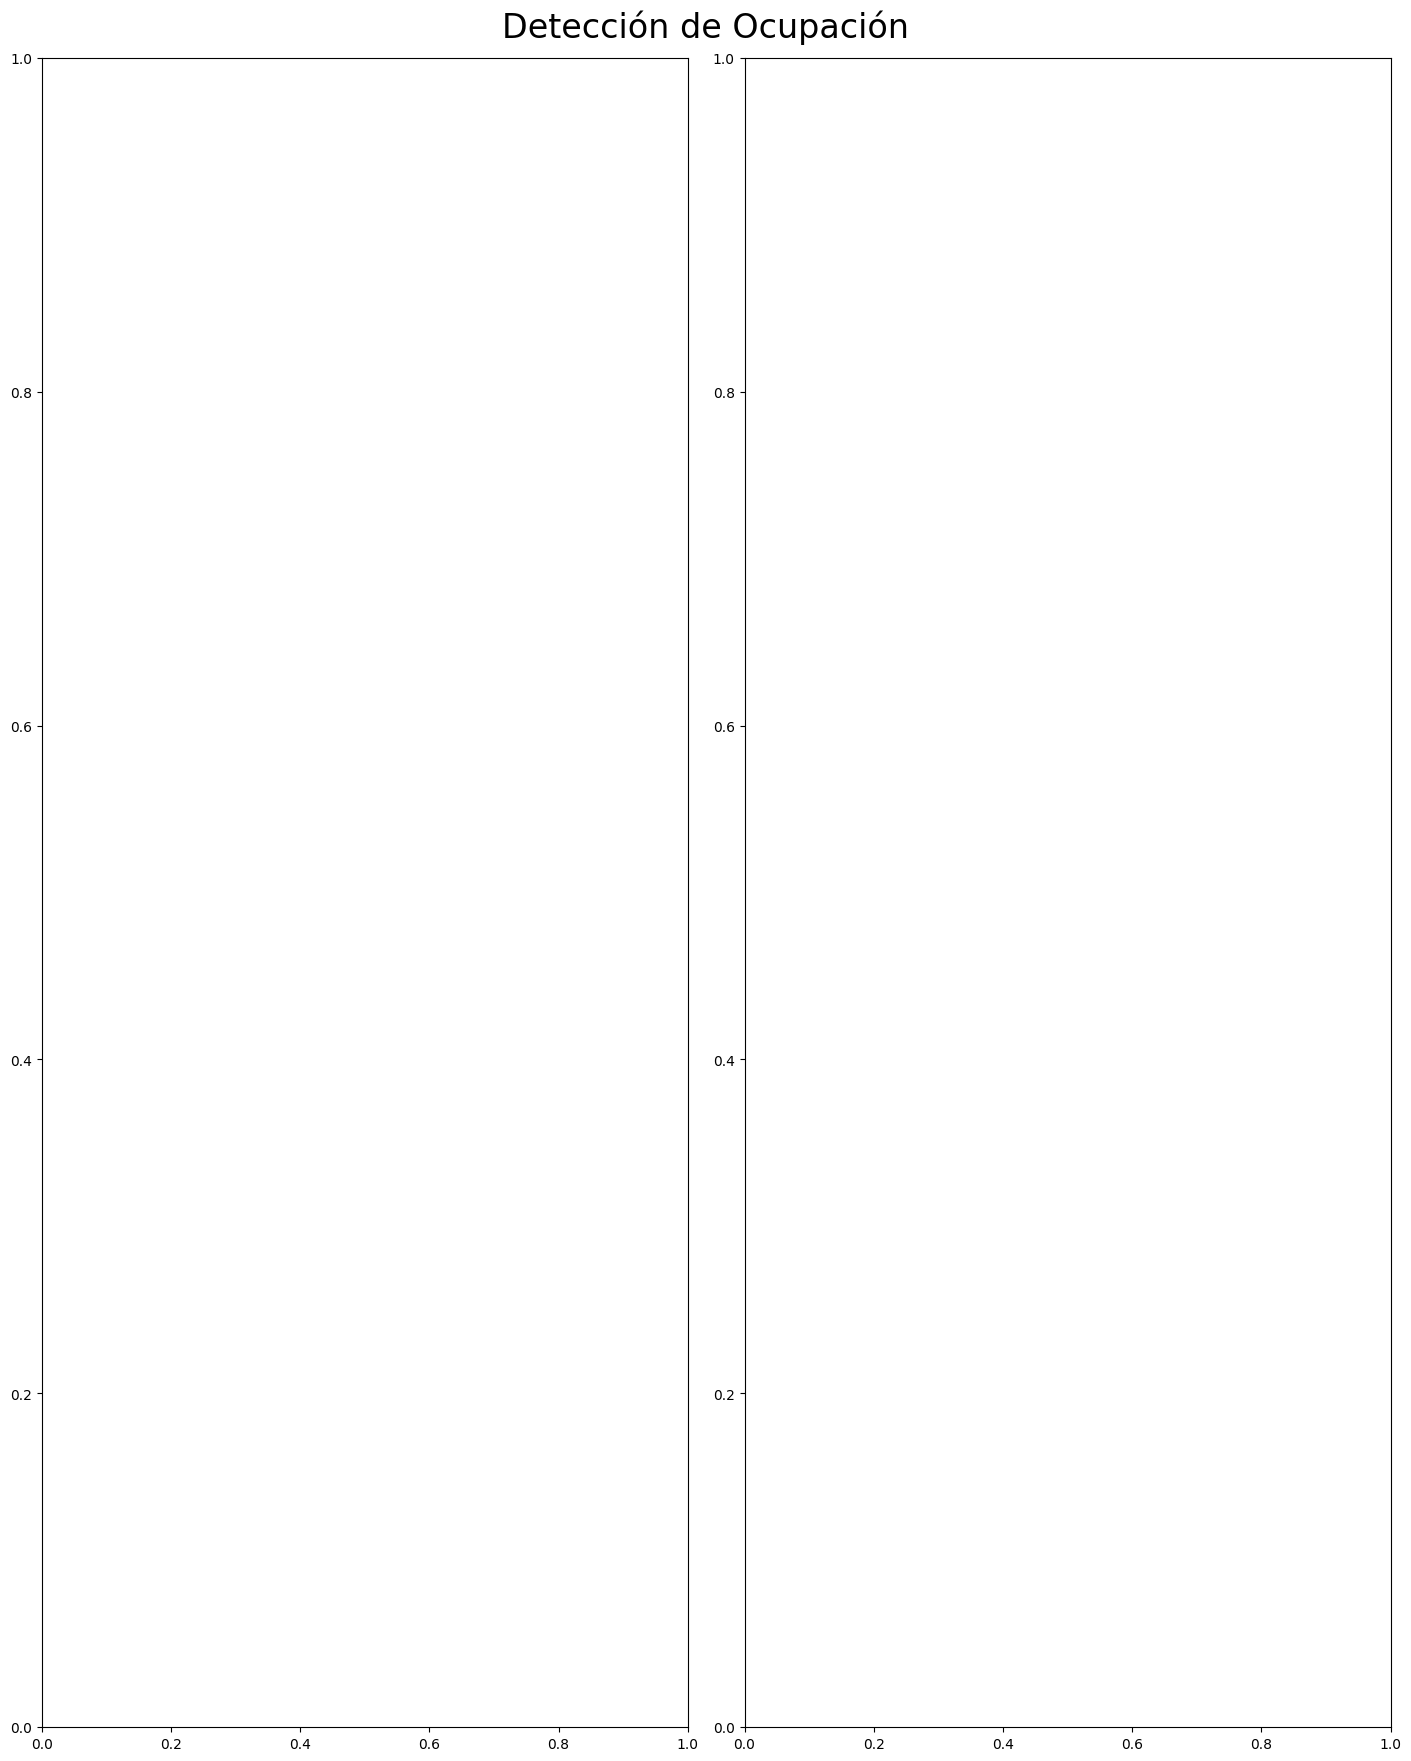

In [47]:
Graficar_Multicategoria("Detección de Ocupación", 
         Resultados_MC, Modelos_MC, ocupacion_train, 
         alfas_mc, betas_mc, [(1,0,0), (0,1,0)])